## Import library

In [1]:
import numpy as np
import pandas as pd 
import os
import tensorflow as tf
from keras.utils import to_categorical
from keras.preprocessing.image import array_to_img, img_to_array, load_img, ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random

Using TensorFlow backend.


## Buat dataframe untuk file-file training

In [2]:
filenames = os.listdir("../cats_and_dogs_filtered/train")
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append(1)
    else:
        categories.append(0)

In [3]:
train_df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

## Ambil contoh file training

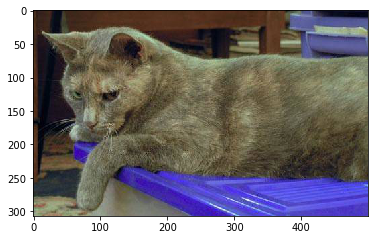

In [4]:
sample = random.choice(filenames)
image = load_img("../cats_and_dogs_filtered/train/"+sample)
plt.imshow(image)

## Berikan category dalam bentuk string

In [5]:
str_cat = []
for n in train_df['category']:
    if n == 0:
        str_cat.append('cat')
    else:
        str_cat.append('dog')

In [6]:
train_df['category_str'] = str_cat
train_df

,filename,category,category_str
0,cat.0.jpg,0,cat
1,cat.1.jpg,0,cat
2,cat.10.jpg,0,cat
3,cat.100.jpg,0,cat
4,cat.101.jpg,0,cat
...,...,...,...
1995,dog.995.jpg,1,dog
1996,dog.996.jpg,1,dog
1997,dog.997.jpg,1,dog
1998,dog.998.jpg,1,dog


Terdapat 1000 gambar kucing dan 1000 gambar anjing

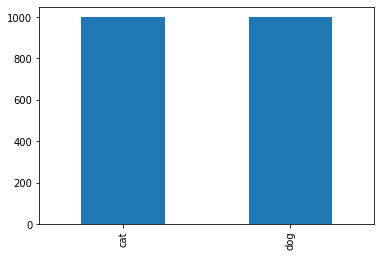

In [7]:
train_df['category_str'].value_counts().plot.bar()

## Dataframe untuk file-file validasi

In [8]:
filenames_val = os.listdir("../cats_and_dogs_filtered/validation")
categories_val = []
for filename in filenames_val:
    category = filename.split('.')[0]
    if category == 'dog':
        categories_val.append(1)
    else:
        categories_val.append(0)

In [9]:
validate_df = pd.DataFrame({
    'filename': filenames_val,
    'category': categories_val
})

In [10]:
str_cat_val = []
for n in validate_df['category']:
    if n == 0:
        str_cat_val.append('cat')
    else:
        str_cat_val.append('dog')
        
validate_df['category_str'] = str_cat_val

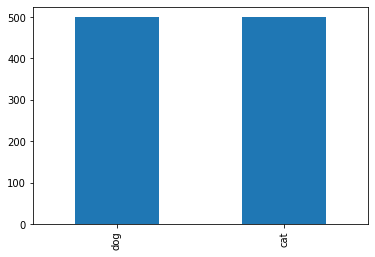

In [11]:
validate_df['category_str'].value_counts().plot.bar()

500 gambar anjing dan 500 gambar kucing

## Contoh gambar validasi

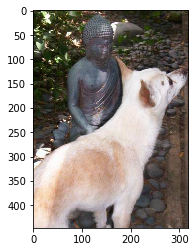

In [12]:
sample = random.choice(filenames_val)
image = load_img("../cats_and_dogs_filtered/validation/"+sample)
plt.imshow(image)

## Konstanta untuk image generator dan model

In [13]:
IMAGE_WIDTH = 128
IMAGE_HEIGHT = 128
IMAGE_SIZE =(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS = 3
BATCH_SIZE = 16

Tetapkan ukuran gambar, dan ukuran batch. Berdasarkan Aurélien Géron dalam buku Hands-On Machine Learning..., ukuran batch lebih baik di bawah 32

## Train Generator dari file-file training

In [14]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

In [15]:
train_gen = train_datagen.flow_from_dataframe(
    train_df,
    "../cats_and_dogs_filtered/train/",
    x_col='filename',
    y_col='category_str',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=BATCH_SIZE
)

Found 2000 validated image filenames belonging to 2 classes.


## Validation generator dari file-file validasi

In [16]:
validation_datagen = ImageDataGenerator(rescale=1./255)

validation_gen = validation_datagen.flow_from_dataframe(
    validate_df,
    "../cats_and_dogs_filtered/validation",
    x_col='filename',
    y_col='category_str',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=BATCH_SIZE
)

Found 1000 validated image filenames belonging to 2 classes.


## Ambil contoh file training yang sudah di-generate

In [17]:
example_df = train_df.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    example_df, 
    "../cats_and_dogs_filtered/train/", 
    x_col='filename',
    y_col='category_str',
    target_size=IMAGE_SIZE,
    class_mode='categorical'
)

Found 1 validated image filenames belonging to 1 classes.


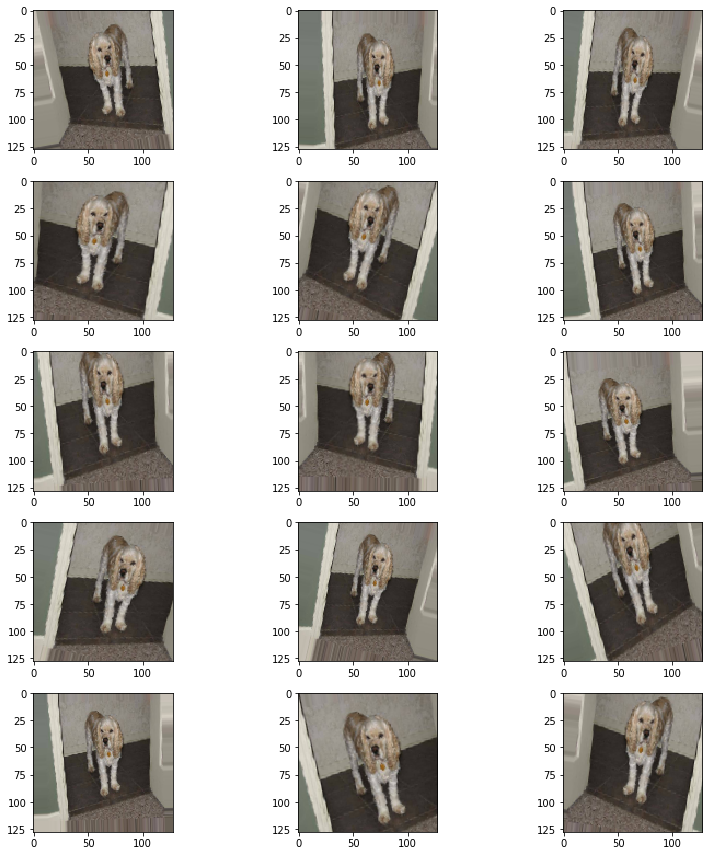

In [18]:
plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

## Buat dan bangun model

In [19]:
model = tf.keras.models.Sequential([
    
    tf.keras.layers.Conv2D(32,(3,3), activation='relu', padding="same", input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)),
    tf.keras.layers.MaxPool2D((2,2)),
    tf.keras.layers.Dropout(0.25),
    
    tf.keras.layers.Conv2D(64,(3,3), activation='relu', padding="same"),
    tf.keras.layers.MaxPool2D((2,2)),
    tf.keras.layers.Dropout(0.25),
    
    tf.keras.layers.Conv2D(64,(3,3), activation='relu', padding="same"),
    tf.keras.layers.MaxPool2D((2,2)),
    tf.keras.layers.Dropout(0.25),
        
    tf.keras.layers.Conv2D(128,(3,3), activation='relu', padding="same"),
    tf.keras.layers.MaxPool2D((2,2)),
    tf.keras.layers.Dropout(0.25),
    
    tf.keras.layers.Conv2D(128,(3,3), activation='relu', padding="same"),
    tf.keras.layers.MaxPool2D((2,2)),
    
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(2, activation='sigmoid')
        
])

model.compile(
    loss = 'binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        3

5 layer convolutional dengan activation 'relu'. Ukuran input menggunakan konstanta yang sudah ditetapkan.
1 layer fully connected. Layer output menggunakan aktivasi 'sigmoid' untuk klasifikasi binary. 
Compile model. Loss function menggunakan binary crossentropy untuk klasifikasi binary.

## Menetapkan callbacks, reduce learning rate dan early stop

In [20]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [21]:
earlystop = tf.keras.callbacks.EarlyStopping(patience=10)

In [22]:
learning_rate_reduction = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [23]:
callbacks = [earlystop, learning_rate_reduction]

In [24]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]

## Fit model

In [25]:
history = model.fit_generator(
    train_gen, 
    epochs=10,
    validation_data=validation_gen,
    validation_steps=total_validate//BATCH_SIZE,
    steps_per_epoch=total_train//BATCH_SIZE,
    callbacks=callbacks
)

Epoch 1/10
125/125 [==============================] - 54s 434ms/step - loss: 0.6975 - accuracy: 0.4895 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 2/10
125/125 [==============================] - 56s 445ms/step - loss: 0.6935 - accuracy: 0.5010 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 3/10
124/125 [============================>.] - ETA: 0s - loss: 0.6933 - accuracy: 0.5066
Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
125/125 [==============================] - 65s 516ms/step - loss: 0.6934 - accuracy: 0.5060 - val_loss: 0.6926 - val_accuracy: 0.5000
Epoch 4/10
125/125 [==============================] - 64s 509ms/step - loss: 0.6928 - accuracy: 0.5135 - val_loss: 0.6899 - val_accuracy: 0.5101
Epoch 5/10
125/125 [==============================] - 71s 571ms/step - loss: 0.6945 - accuracy: 0.5368 - val_loss: 0.6893 - val_accuracy: 0.6305
Epoch 6/10
125/125 [==============================] - 78s 624ms/step - loss: 0.6869 - accuracy: 0.5615 - val_l

In [26]:
history = model.fit_generator(
    train_gen, 
    epochs=25,
    validation_data=validation_gen,
    validation_steps=total_validate//BATCH_SIZE,
    steps_per_epoch=total_train//BATCH_SIZE,
    callbacks=callbacks
)

Epoch 1/25
125/125 [==============================] - 54s 435ms/step - loss: 0.6403 - accuracy: 0.6242 - val_loss: 0.6330 - val_accuracy: 0.6351
Epoch 2/25
125/125 [==============================] - 54s 436ms/step - loss: 0.6291 - accuracy: 0.6258 - val_loss: 0.6114 - val_accuracy: 0.6613
Epoch 3/25
125/125 [==============================] - 56s 449ms/step - loss: 0.6176 - accuracy: 0.6545 - val_loss: 0.5943 - val_accuracy: 0.6981
Epoch 4/25
125/125 [==============================] - 55s 444ms/step - loss: 0.6024 - accuracy: 0.6630 - val_loss: 0.5860 - val_accuracy: 0.6855
Epoch 5/25
125/125 [==============================] - 56s 452ms/step - loss: 0.6072 - accuracy: 0.6607 - val_loss: 0.5796 - val_accuracy: 0.7031
Epoch 6/25
125/125 [==============================] - 56s 447ms/step - loss: 0.5931 - accuracy: 0.6790 - val_loss: 0.5682 - val_accuracy: 0.7077
Epoch 7/25
125/125 [==============================] - 56s 450ms/step - loss: 0.5832 - accuracy: 0.6930 - val_loss: 0.5691 - val_ac

In [27]:
history = model.fit_generator(
    train_gen, 
    epochs=10,
    validation_data=validation_gen,
    validation_steps=total_validate//BATCH_SIZE,
    steps_per_epoch=total_train//BATCH_SIZE,
    callbacks=callbacks
)

Epoch 1/10
125/125 [==============================] - 57s 457ms/step - loss: 0.4839 - accuracy: 0.7530 - val_loss: 0.5694 - val_accuracy: 0.6991
Epoch 2/10
125/125 [==============================] - 55s 436ms/step - loss: 0.4816 - accuracy: 0.7617 - val_loss: 0.5612 - val_accuracy: 0.7046
Epoch 3/10
125/125 [==============================] - 54s 436ms/step - loss: 0.4912 - accuracy: 0.7592 - val_loss: 0.5629 - val_accuracy: 0.7036
Epoch 4/10
125/125 [==============================] - 55s 437ms/step - loss: 0.4859 - accuracy: 0.7580 - val_loss: 0.5637 - val_accuracy: 0.7036
Epoch 5/10
125/125 [==============================] - 55s 437ms/step - loss: 0.4945 - accuracy: 0.7490 - val_loss: 0.5555 - val_accuracy: 0.7061
Epoch 6/10
125/125 [==============================] - 55s 441ms/step - loss: 0.4835 - accuracy: 0.7695 - val_loss: 0.5630 - val_accuracy: 0.7031
Epoch 7/10
125/125 [==============================] - 61s 486ms/step - loss: 0.4833 - accuracy: 0.7635 - val_loss: 0.5571 - val_ac

In [28]:
history = model.fit_generator(
    train_gen, 
    epochs=25,
    validation_data=validation_gen,
    validation_steps=total_validate//BATCH_SIZE,
    steps_per_epoch=total_train//BATCH_SIZE,
    callbacks=callbacks
)

Epoch 1/25
125/125 [==============================] - 62s 492ms/step - loss: 0.4834 - accuracy: 0.7535 - val_loss: 0.5824 - val_accuracy: 0.6920
Epoch 2/25
125/125 [==============================] - 59s 472ms/step - loss: 0.4859 - accuracy: 0.7660 - val_loss: 0.5868 - val_accuracy: 0.6935
Epoch 3/25
125/125 [==============================] - 60s 478ms/step - loss: 0.4896 - accuracy: 0.7580 - val_loss: 0.5766 - val_accuracy: 0.6951
Epoch 4/25
125/125 [==============================] - 61s 488ms/step - loss: 0.4816 - accuracy: 0.7613 - val_loss: 0.5577 - val_accuracy: 0.7102
Epoch 5/25
125/125 [==============================] - 61s 485ms/step - loss: 0.4787 - accuracy: 0.7717 - val_loss: 0.5728 - val_accuracy: 0.6941
Epoch 6/25
125/125 [==============================] - 61s 490ms/step - loss: 0.4790 - accuracy: 0.7692 - val_loss: 0.5750 - val_accuracy: 0.6996
Epoch 7/25
125/125 [==============================] - 61s 490ms/step - loss: 0.4783 - accuracy: 0.7605 - val_loss: 0.5656 - val_ac

In [47]:
history = model.fit_generator(
    train_gen, 
    epochs=20,
    validation_data=validation_gen,
    validation_steps=total_validate//BATCH_SIZE,
    steps_per_epoch=total_train//BATCH_SIZE,
    callbacks=callbacks
)

Epoch 1/20
125/125 [==============================] - 55s 441ms/step - loss: 0.4736 - accuracy: 0.7655 - val_loss: 0.5543 - val_accuracy: 0.7182
Epoch 2/20
125/125 [==============================] - 61s 486ms/step - loss: 0.4608 - accuracy: 0.7872 - val_loss: 0.5752 - val_accuracy: 0.7056
Epoch 3/20
125/125 [==============================] - 62s 496ms/step - loss: 0.4651 - accuracy: 0.7740 - val_loss: 0.5700 - val_accuracy: 0.7082
Epoch 4/20
125/125 [==============================] - 63s 500ms/step - loss: 0.4662 - accuracy: 0.7695 - val_loss: 0.5705 - val_accuracy: 0.7072
Epoch 5/20
125/125 [==============================] - 62s 498ms/step - loss: 0.4651 - accuracy: 0.7760 - val_loss: 0.5740 - val_accuracy: 0.7041
Epoch 6/20
125/125 [==============================] - 61s 490ms/step - loss: 0.4631 - accuracy: 0.7815 - val_loss: 0.5492 - val_accuracy: 0.7248
Epoch 7/20
125/125 [==============================] - 62s 495ms/step - loss: 0.4695 - accuracy: 0.7715 - val_loss: 0.5876 - val_ac

In [48]:
history = model.fit_generator(
    train_gen, 
    epochs=5,
    validation_data=validation_gen,
    validation_steps=total_validate//BATCH_SIZE,
    steps_per_epoch=total_train//BATCH_SIZE,
    callbacks=callbacks
)

Epoch 1/5
125/125 [==============================] - 59s 469ms/step - loss: 0.4526 - accuracy: 0.7865 - val_loss: 0.5651 - val_accuracy: 0.7167
Epoch 2/5
125/125 [==============================] - 58s 462ms/step - loss: 0.4550 - accuracy: 0.7878 - val_loss: 0.5756 - val_accuracy: 0.7072
Epoch 3/5
125/125 [==============================] - 56s 449ms/step - loss: 0.4494 - accuracy: 0.7868 - val_loss: 0.5581 - val_accuracy: 0.7177
Epoch 4/5
125/125 [==============================] - 58s 463ms/step - loss: 0.4614 - accuracy: 0.7770 - val_loss: 0.5593 - val_accuracy: 0.7182
Epoch 5/5
125/125 [==============================] - 59s 470ms/step - loss: 0.4547 - accuracy: 0.7977 - val_loss: 0.5571 - val_accuracy: 0.7208


In [49]:
history = model.fit_generator(
    train_gen, 
    epochs=10,
    validation_data=validation_gen,
    validation_steps=total_validate//BATCH_SIZE,
    steps_per_epoch=total_train//BATCH_SIZE,
    callbacks=callbacks
)

Epoch 1/10
125/125 [==============================] - 59s 468ms/step - loss: 0.4549 - accuracy: 0.7818 - val_loss: 0.5639 - val_accuracy: 0.7157
Epoch 2/10
125/125 [==============================] - 59s 474ms/step - loss: 0.4586 - accuracy: 0.7703 - val_loss: 0.5934 - val_accuracy: 0.6961
Epoch 3/10
125/125 [==============================] - 57s 456ms/step - loss: 0.4530 - accuracy: 0.7772 - val_loss: 0.5619 - val_accuracy: 0.7162
Epoch 4/10
125/125 [==============================] - 55s 439ms/step - loss: 0.4513 - accuracy: 0.7862 - val_loss: 0.5718 - val_accuracy: 0.7142
Epoch 5/10
125/125 [==============================] - 55s 441ms/step - loss: 0.4514 - accuracy: 0.7822 - val_loss: 0.5672 - val_accuracy: 0.7127
Epoch 6/10
125/125 [==============================] - 55s 440ms/step - loss: 0.4597 - accuracy: 0.7790 - val_loss: 0.5657 - val_accuracy: 0.7167
Epoch 7/10
125/125 [==============================] - 56s 444ms/step - loss: 0.4536 - accuracy: 0.7885 - val_loss: 0.5795 - val_ac

In [51]:
history = model.fit_generator(
    train_gen, 
    epochs=5,
    validation_data=validation_gen,
    validation_steps=total_validate//BATCH_SIZE,
    steps_per_epoch=total_train//BATCH_SIZE,
    callbacks=callbacks
)

Epoch 1/5
125/125 [==============================] - 55s 437ms/step - loss: 0.4498 - accuracy: 0.7925 - val_loss: 0.5897 - val_accuracy: 0.7036
Epoch 2/5
125/125 [==============================] - 55s 441ms/step - loss: 0.4472 - accuracy: 0.7893 - val_loss: 0.5917 - val_accuracy: 0.7026
Epoch 3/5
125/125 [==============================] - 55s 443ms/step - loss: 0.4511 - accuracy: 0.7812 - val_loss: 0.5558 - val_accuracy: 0.7208
Epoch 4/5
125/125 [==============================] - 55s 441ms/step - loss: 0.4458 - accuracy: 0.7903 - val_loss: 0.5815 - val_accuracy: 0.7097
Epoch 5/5
125/125 [==============================] - 59s 469ms/step - loss: 0.4630 - accuracy: 0.7745 - val_loss: 0.5804 - val_accuracy: 0.7077


## Total epoch = 10 + 24 + 10 + 25 + 16 + 5 + 10 + 5 = 105

In [80]:
10+24+10+25+16+5+10+5

105

Training model dilakukan berkali-kali sambil memantau model. Ternyata diperlukan epoch yang besar supaya memperoleh nilai validation accuration yang tinggi. 

## Peroleh nilai validasi model

In [52]:
model.evaluate(validation_gen)

63/63 [==============================] - 5s 80ms/step - loss: 0.5781 - accuracy: 0.7080


[0.5780651370684305, 0.708]

## Persiapkan file-file untuk prediksi dengan model yang sudah dijalankan

In [53]:
filenames_test = os.listdir("../cats_and_dogs_filtered/test")

test_df = pd.DataFrame({
    'filename': filenames_test
})

In [54]:
nb_samples = test_df.shape[0]

In [55]:
test_gen = ImageDataGenerator(rescale=1./255, zoom_range=0.3)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    "../cats_and_dogs_filtered/test", 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 22 validated image filenames.


Menggunakan zoom_range supaya dapat lebih mengetahui gambar yang akan diprediksi

## Prediksi file-file test dengan model

In [56]:
predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/BATCH_SIZE))

In [57]:
test_df['category'] = np.argmax(predict, axis=-1)

In [58]:
label_map = dict((v,k) for k,v in train_gen.class_indices.items())
test_df['category'] = test_df['category'].replace(label_map)

In [59]:
test_df

,filename,category
0,cat.1.jpeg,cat
1,cat.10.jpg,cat
2,cat.11.jpg,dog
3,cat.2.jpeg,cat
4,cat.3.jpg,dog
5,cat.4.jpg,cat
6,cat.5.jpg,dog
7,cat.6.jpg,dog
8,cat.7.jpg,cat
9,cat.8.jpg,cat


## Tampilkan file-file gambar test yang sudah di-generate beserta hasil prediksi sebagai judul gambar

In [60]:
import matplotlib.image as mpimg 
import matplotlib.pyplot as plt 

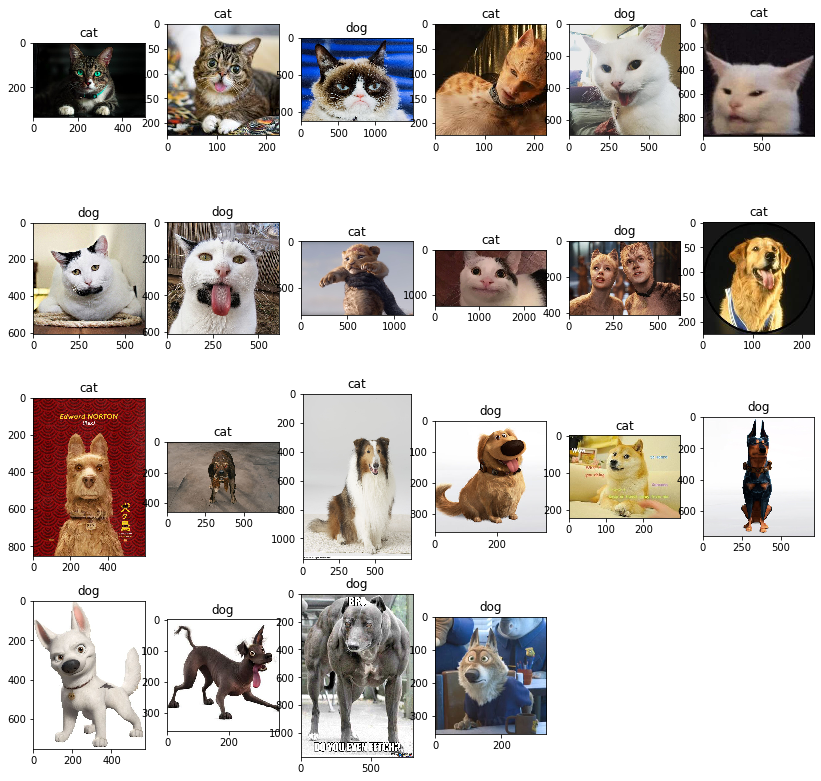

In [70]:
plt.figure(figsize=(14, 14))
plt.subplot(461)
img = mpimg.imread('../cats_and_dogs_filtered/test/cat.1.jpeg')
plt.title(test_df['category'][0])
plt.imshow(img)

plt.subplot(462)
img1 = mpimg.imread('../cats_and_dogs_filtered/test/cat.10.jpg')
plt.title(test_df['category'][1])
plt.imshow(img1)

plt.subplot(463)
img2 = mpimg.imread('../cats_and_dogs_filtered/test/cat.11.jpg')
plt.title(test_df['category'][2])
plt.imshow(img2)

plt.subplot(464)
img3 = mpimg.imread('../cats_and_dogs_filtered/test/cat.2.jpeg')
plt.title(test_df['category'][3])
plt.imshow(img3)

plt.subplot(465)
img4 = mpimg.imread('../cats_and_dogs_filtered/test/cat.3.jpg')
plt.title(test_df['category'][4])
plt.imshow(img4)

plt.subplot(466)
img5 = mpimg.imread('../cats_and_dogs_filtered/test/cat.4.jpg')
plt.title(test_df['category'][5])
plt.imshow(img5)

plt.subplot(467)
img6 = mpimg.imread('../cats_and_dogs_filtered/test/cat.5.jpg')
plt.title(test_df['category'][6])
plt.imshow(img6)

plt.subplot(468)
img7 = mpimg.imread('../cats_and_dogs_filtered/test/cat.6.jpg')
plt.title(test_df['category'][7])
plt.imshow(img7)

plt.subplot(469)
img8 = mpimg.imread('../cats_and_dogs_filtered/test/cat.7.jpg')
plt.title(test_df['category'][8])
plt.imshow(img8)

plt.subplot(4,6,10)
img9 = mpimg.imread('../cats_and_dogs_filtered/test/cat.8.jpg')
plt.title(test_df['category'][9])
plt.imshow(img9)

plt.subplot(4,6,11)
img10 = mpimg.imread('../cats_and_dogs_filtered/test/cat.9.jpg')
plt.title(test_df['category'][10])
plt.imshow(img10)

plt.subplot(4,6,12)
img11 = mpimg.imread('../cats_and_dogs_filtered/test/dog.1.jpeg')
plt.title(test_df['category'][11])
plt.imshow(img11)

plt.subplot(4,6,13)
img12 = mpimg.imread('../cats_and_dogs_filtered/test/dog.10.jpg')
plt.title(test_df['category'][12])
plt.imshow(img12)

plt.subplot(4,6,14)
img13 = mpimg.imread('../cats_and_dogs_filtered/test/dog.11.jpg')
plt.title(test_df['category'][13])
plt.imshow(img13)

plt.subplot(4,6,15)
img14 = mpimg.imread('../cats_and_dogs_filtered/test/dog.2.jpeg')
plt.title(test_df['category'][14])
plt.imshow(img14)

plt.subplot(4,6,16)
img15 = mpimg.imread('../cats_and_dogs_filtered/test/dog.3.jpeg')
plt.title(test_df['category'][15])
plt.imshow(img15)

plt.subplot(4,6,17)
img16 = mpimg.imread('../cats_and_dogs_filtered/test/dog.4.jpg')
plt.title(test_df['category'][16])
plt.imshow(img16)

plt.subplot(4,6,18)
img17 = mpimg.imread('../cats_and_dogs_filtered/test/dog.5.jpg')
plt.title(test_df['category'][17])
plt.imshow(img17)

plt.subplot(4,6,19)
img18 = mpimg.imread('../cats_and_dogs_filtered/test/dog.6.jpg')
plt.title(test_df['category'][18])
plt.imshow(img18)

plt.subplot(4,6,20)
img19 = mpimg.imread('../cats_and_dogs_filtered/test/dog.7.jpg')
plt.title(test_df['category'][19])
plt.imshow(img19)

plt.subplot(4,6,21)
img20 = mpimg.imread('../cats_and_dogs_filtered/test/dog.8.jpg')
plt.title(test_df['category'][20])
plt.imshow(img20)

plt.subplot(4,6,22)
img21 = mpimg.imread('../cats_and_dogs_filtered/test/dog.9.jpg')
plt.title(test_df['category'][21])
plt.imshow(img21)

Cara manual

Test file Kucing = 11 file gambar
Test file Anjing = 11 file gambar

6/10 prediksi benar untuk gambar Kucing
6/10 prediksi benar untuk gambar Anjing

## Tampilkan grafik perubahan nilai loss dan nilai akurasi dari saat training model

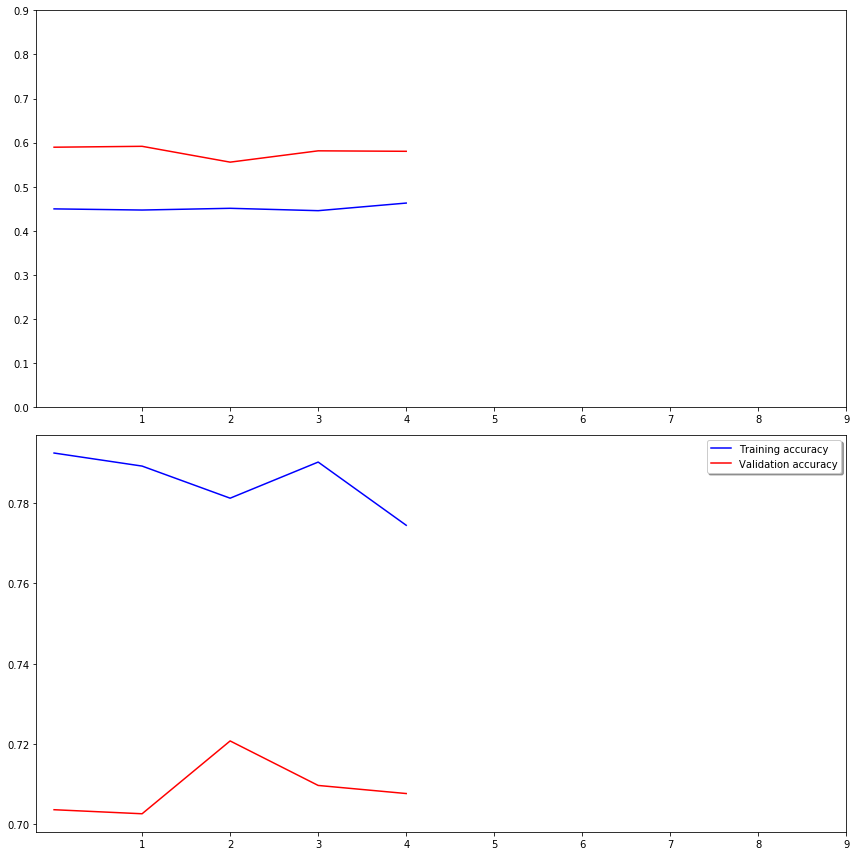

In [79]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, 10, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, 10, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()



Karena running model dilakukan berkali-kali, nilai epoch yang terrekam di "history" hanyalah dari running model yang terakhir, yaitu 5, sehingga perubahan nilai loss dan akurasi tidak terlihat.

## Save model

In [81]:
model.save("CatDog-Classifications.h5")
model.save_weight()